__Reference Article__: https://www.learnpytorch.io/02_pytorch_classification/

__Reference GitHub__: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb


## 02. Neural Network Classification with PyTorch

### 1. Make Classification data ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 2000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(2000, 2000)

In [ ]:
print(f"First 5 values of X: \n", X[:5])
print(f"First 5 values of y: \n", y[:5])

First 5 values of X: 
 [[ 0.47109875 -0.58158579]
 [-0.61696058  0.80818956]
 [-0.3999557   0.70796779]
 [ 0.82938523 -0.60057314]
 [-0.16419138  0.76128858]]
First 5 values of y: 
 [1 0 1 0 1]


In [ ]:
# Make dataframe of circles
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.471099,-0.581586,1
1,-0.616961,0.808190,0
2,-0.399956,0.707968,1
3,0.829385,-0.600573,0
4,-0.164191,0.761289,1
5,-0.161906,0.778817,1
6,0.970100,-0.354272,0
7,-0.105737,-0.804784,1
8,0.908106,0.459450,0
9,-0.342749,0.730214,1


In [ ]:
# values count for label
circles['label'].value_counts()

1    1000
0    1000
Name: label, dtype: int64

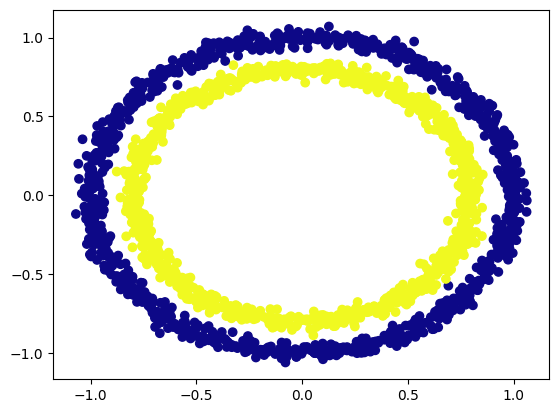

In [ ]:
# visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.plasma)

In [ ]:
# View the first example of featuress and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X:{X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [ 0.47109875 -0.58158579] and the same for y: 1
Shapes for one sample of X:(2,) and the same for y: ()


### 1.1 Turn our data into tensors and create a train test split

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
type(X) # Now its tensor but it was numpy.ndarray

numpy.ndarray

In [ ]:
# turn our data into tensors
X= torch.from_numpy(X).type(torch.float) # default float is float32 in pytorch
y= torch.from_numpy(y).type(torch.float)

# view first 5 samples
X[:5], y[:5]

(tensor([[ 0.4711, -0.5816],
         [-0.6170,  0.8082],
         [-0.4000,  0.7080],
         [ 0.8294, -0.6006],
         [-0.1642,  0.7613]]),
 tensor([1., 0., 1., 0., 1.]))

## Split the data into train and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(1600, 400, 1600, 400)

## Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

 1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
 2. Constructing a model by subclassing nn.Module.
 3. Defining a loss function and optimizer.
 4. Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and torch.nn as well as setting up device agnostic code.

In [ ]:
# standard pytorch imports
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
# 1. Construct the model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input data,
    # as well as shape of it.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # taking in 2 features and upscale to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature


  # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x-> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# lets replicate the above model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3348,  0.2564],
                      [-0.5956,  0.6987],
                      [ 0.4128, -0.3454],
                      [-0.1799, -0.4013],
                      [ 0.1532,  0.5756]])),
             ('0.bias', tensor([ 0.0521,  0.0232, -0.4554, -0.3816, -0.3435])),
             ('1.weight',
              tensor([[ 0.4375,  0.1020,  0.0572,  0.4154, -0.4040]])),
             ('1.bias', tensor([0.2551]))])

In [ ]:
# Make predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 400, Shape: torch.Size([400, 1])
Length of test samples: 400, Shape: torch.Size([400])

First 10 predictions:
tensor([[ 0.5118],
        [ 0.5566],
        [ 0.6419],
        [ 0.3464],
        [-0.1465],
        [ 0.3813],
        [ 0.1849],
        [-0.0542],
        [ 0.2387],
        [ 0.5589]])

First 10 test labels:
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1.])


Hmm, it seems there's the same amount of predictions as there is test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.

## Setup a optimizer and loss function

WHich loss function or optimizer should you use?

Again... this problem specific

For example for regression you might want MSE or MAE.

For binary classification problem(like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

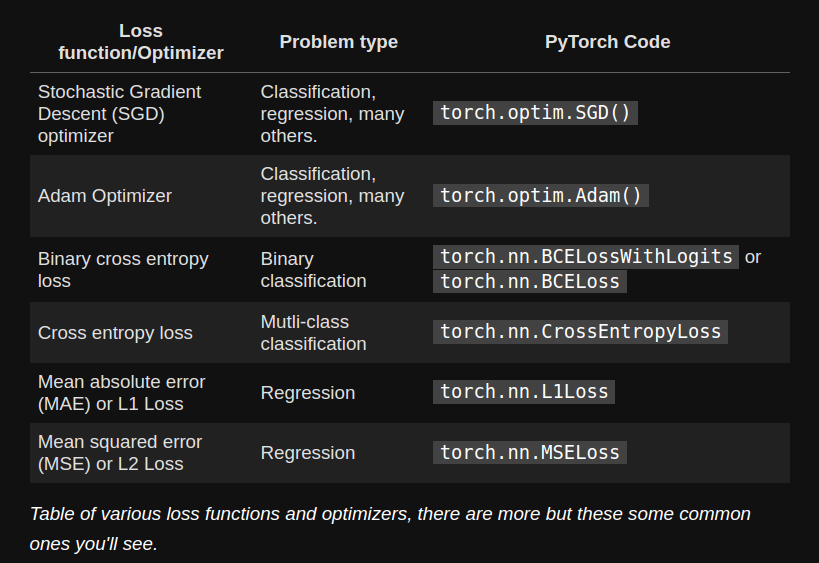

In [ ]:
# setup a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

# setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy using evaluation metrics
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


## 3. Train model

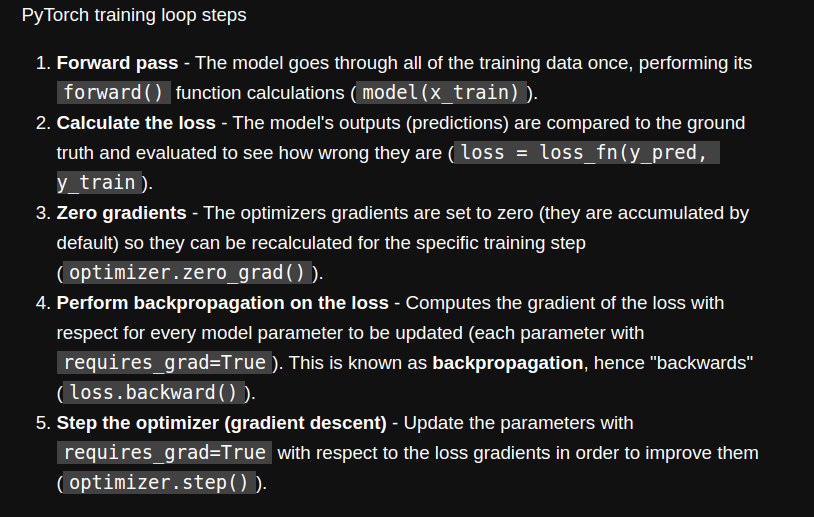

## 3.1 Going from raw logits -> prediction probabilities -> prediction labels


In [ ]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.5118],
        [ 0.5566],
        [ 0.6419],
        [ 0.3464],
        [-0.1465]], grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

The raw outputs (unmodified) of this equation (
) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data (
 in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.



In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6252],
        [0.6357],
        [0.6552],
        [0.5857],
        [0.4634]], grad_fn=<SigmoidBackward0>)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.], grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 1., 0., 1., 0.])

## Building a training and testing loops

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  ## 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits -> pred probs -> label

  ## 2. Loss / Accuracy
  loss = loss_fn(y_logits)
